First, read in the data and check out the columns:

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
fpp_all = pd.read_csv('fpp_final_table.csv', index_col=0)
fpp_all.count()

koi.1                    8826
rprs                     8440
secthresh                8440
maxrad                   8440
pr_heb                   8145
pr_heb_Px2               8145
pr_eb                    8145
pr_eb_Px2                8145
pr_beb                   8145
pr_beb_Px2               8145
L_tot                    8148
fp                       8148
FPP                      8145
kepid                    8826
period                   8826
rp                       8321
disposition              8826
prob_ontarget            6786
pos_prob_score           7470
not_transitlike          8826
significant_secondary    8826
centroid_offset          8826
ephem_match              8826
exception                 678
has_ttv                  8556
MES                      7470
dtype: int64

Now, we want to split up this whole population into distinct subsets, based on sequential categorizations, in the following order:

* Archive disposition (based on the cumulative table). CONFIRMED and FALSE POSITIVE are their own category; CANDIDATE gets further subdivided.  
* Whether the `vespa` calculation worked or not.
* Whether positional probability calculation is reliable (based on `prob_score_thresh`).  Unreliable goes into "uncertain" category; 
* Reliable positional probs gets further divided based on prob > 0.99 or not.
* Positional prob > 0.99 gets further divided by FPP.  The "newly validated" subset is the subset of these with FPP < 0.01

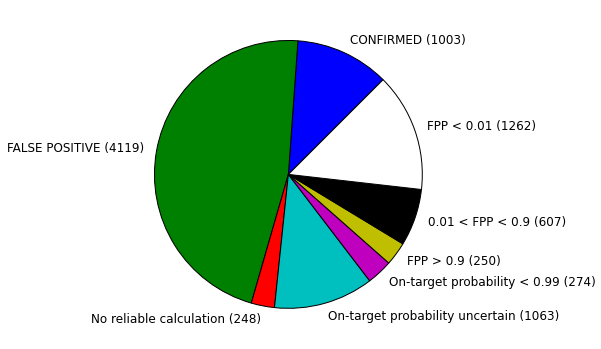

In [7]:
prob_score_thresh = 0.3

confirmed = fpp_all['disposition'] == 'CONFIRMED'
known_fp = fpp_all['disposition'] == 'FALSE POSITIVE'
candidate = fpp_all['disposition'] == 'CANDIDATE'
low_fpp = fpp_all['FPP'] < 0.01
hi_fpp = fpp_all['FPP'] > 0.9
med_fpp = (fpp_all['FPP'] >= 0.01) & (fpp_all['FPP'] <=0.9)
on_target = (fpp_all['prob_ontarget'] >= 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
off_target = (fpp_all['prob_ontarget'] < 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
target_ambiguous = ((fpp_all['pos_prob_score'] < prob_score_thresh) | 
                    np.isnan(fpp_all['pos_prob_score']) | 
                    np.isnan(fpp_all['prob_ontarget']))
not_crazy = fpp_all['L_tot'] > 1e-3
crazy = fpp_all['L_tot'] <= 1e-3

fpp_calculated = np.isfinite(fpp_all['FPP']) #whether FPP calculation worked

##Just some checks to see if things add up properly
#reliable = (confirmed | candidate) & on_target & not_crazy
#print(sum(reliable))
#print(sum(reliable & low_fpp))
#print(sum(candidate & on_target & not_crazy & low_fpp))
#print(sum(confirmed))
#print(sum(candidate & high_fpp))
#print(sum(confirmed & high_fpp))

newfp = (candidate & fpp_calculated & not_crazy & on_target & hi_fpp)
newmed = (candidate & fpp_calculated & not_crazy & on_target & med_fpp)
newval = (candidate & fpp_calculated & not_crazy & on_target & low_fpp)

categories = [ confirmed, known_fp, 
              (candidate & ~fpp_calculated) | (candidate & fpp_calculated & crazy),
              (candidate & fpp_calculated & not_crazy & target_ambiguous),
              (candidate & fpp_calculated & not_crazy & off_target),
              newfp, newmed, newval]

labels = ['CONFIRMED ({})'.format(categories[0].sum()),
          'FALSE POSITIVE ({})'.format(categories[1].sum()),
          'No reliable calculation ({})'.format(categories[2].sum()),
          'On-target probability uncertain ({})'.format(categories[3].sum()),
          'On-target probability < 0.99 ({})'.format(categories[4].sum()), 
          'FPP > 0.9 ({})'.format(categories[5].sum()), 
          '0.01 < FPP < 0.9 ({})'.format(categories[6].sum()), 
          'FPP < 0.01 ({})'.format(categories[7].sum())]

needmore = categories[2] | categories[3] | categories[4]

sums = np.array([c.sum() for c in categories])
fracs = sums / float(sums.sum()) * 100

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pie(fracs, labels=labels, startangle=45);

Let's take a look at just the validated subset, and write that to a file:

In [8]:
fpp_all[newval].count()
fpp_all[newval].to_csv('newly_validated.csv')

In [9]:
fpp_all[newval].head()

,koi.1,rprs,secthresh,maxrad,pr_heb,pr_heb_Px2,pr_eb,pr_eb_Px2,pr_beb,pr_beb_Px2,...,rp,disposition,prob_ontarget,pos_prob_score,not_transitlike,significant_secondary,centroid_offset,ephem_match,exception,has_ttv
koi,,,,,,,,,,,,,,,,,,,,,
K00004.01,K00004.01,0.040,66,0.50,1.750000e-03,1.710000e-06,1.990000e-03,9.590000e-06,2.580000e-06,1.030000e-21,...,10.289548,CANDIDATE,1,1,False,True,False,False,NaN,False
K00005.01,K00005.01,0.037,15,0.50,8.750000e-04,3.950000e-05,7.100000e-03,6.790000e-05,8.170000e-05,3.330000e-15,...,7.193851,CANDIDATE,1,1,False,False,False,False,NaN,False
K00049.01,K00049.01,0.026,52,0.50,2.260000e-13,3.620000e-12,1.550000e-63,1.960000e-16,1.150000e-07,2.120000e-35,...,2.580020,CANDIDATE,1,1,False,False,False,False,NaN,False
K00089.01,K00089.01,0.017,34,0.72,6.030000e-45,5.060000e-39,1.420000e-17,5.640000e-51,3.450000e-17,0.000000e+00,...,3.822486,CANDIDATE,1,1,False,False,False,False,NaN,True
K00092.01,K00092.01,0.024,49,0.57,1.010000e-10,9.850000e-10,7.240000e-06,9.210000e-27,6.360000e-06,3.840000e-18,...,2.648501,CANDIDATE,1,1,False,False,False,False,NaN,False


In [11]:
from keputils import koiutils as ku

In [15]:
import re
for c in ku.DATA.columns:
    print c

kepid
kepoi_name
kepler_name
ra
ra_err
ra_str
dec
dec_err
dec_str
koi_gmag
koi_gmag_err
koi_rmag
koi_rmag_err
koi_imag
koi_imag_err
koi_zmag
koi_zmag_err
koi_jmag
koi_jmag_err
koi_hmag
koi_hmag_err
koi_kmag
koi_kmag_err
koi_kepmag
koi_kepmag_err
koi_delivname
koi_vet_stat
koi_quarters
koi_disposition
koi_pdisposition
koi_count
koi_num_transits
koi_max_sngle_ev
koi_max_mult_ev
koi_bin_oedp_sig
koi_limbdark_mod
koi_ldm_coeff4
koi_ldm_coeff3
koi_ldm_coeff2
koi_ldm_coeff1
koi_trans_mod
koi_model_snr
koi_model_dof
koi_model_chisq
koi_time0bk
koi_time0bk_err1
koi_time0bk_err2
koi_eccen
koi_eccen_err1
koi_eccen_err2
koi_longp
koi_longp_err1
koi_longp_err2
koi_prad
koi_prad_err1
koi_prad_err2
koi_sma
koi_sma_err1
koi_sma_err2
koi_impact
koi_impact_err1
koi_impact_err2
koi_duration
koi_duration_err1
koi_duration_err2
koi_ingress
koi_ingress_err1
koi_ingress_err2
koi_depth
koi_depth_err1
koi_depth_err2
koi_period
koi_period_err1
koi_period_err2
koi_ror
koi_ror_err1
koi_ror_err2
koi_dor
koi_dor_e